Загрузка библиотек:

In [274]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Прогоним изначальную модель и получим результаты:

In [275]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

numpy.random.seed(7)

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data = pd.read_csv('/content/drive/MyDrive/airline-passengers.csv', usecols=[1], engine='python')

# dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = data.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

Mounted at /content/drive


In [276]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [277]:
batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	model.reset_states()

In [278]:
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

44/44 [==============================] - 0s 1ms/step


In [279]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [280]:
trainPredictPlot1 = numpy.empty_like(dataset)
trainPredictPlot1[:, :] = numpy.nan
trainPredictPlot1[look_back:len(trainPredict)+look_back, :] = trainPredict

In [281]:
testPredictPlot1 = numpy.empty_like(dataset)
testPredictPlot1[:, :] = numpy.nan
testPredictPlot1[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [282]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Train Score model 1: %.2f RMSE' % (trainScore))
print('Test Score model 1: %.2f RMSE' % (testScore))

Train Score model 1: 51.91 RMSE
Test Score model 1: 129.89 RMSE


Попробуем улучшить результаты:

добавим к оптимизатору скорость обучения :

In [283]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [284]:
batch_size = 1

model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(learning_rate=0.001))

for i in range(100):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	model.reset_states()
 
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainPredictPlot2 = numpy.empty_like(dataset)
trainPredictPlot2[:, :] = numpy.nan
trainPredictPlot2[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot2 = numpy.empty_like(dataset)
testPredictPlot2[:, :] = numpy.nan
testPredictPlot2[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

trainScore2 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore2 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))

44/44 [==============================] - 0s 994us/step


Train Score model 1: 51.91 RMSE
Test Score model 1: 129.89 RMSE
Train Score model 2: 27.84 RMSE
Test Score model 2: 70.63 RMSE



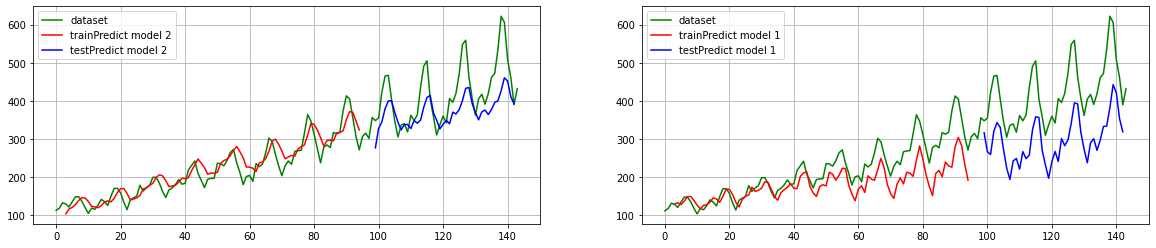

In [285]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(4)
fig.set_figwidth(20)
ax1.plot(scaler.inverse_transform(dataset),'g', label = 'dataset')
ax1.plot(trainPredictPlot2,'r', label = 'trainPredict model 2')
ax1.plot(testPredictPlot2,'b', label = 'testPredict model 2')
ax1.legend()
ax1.grid('On')
ax2.plot(scaler.inverse_transform(dataset),'g', label = 'dataset')
ax2.plot(trainPredictPlot1,'r', label = 'trainPredict model 1')
ax2.plot(testPredictPlot1,'b', label = 'testPredict model 1')
ax2.legend()
ax2.grid('On')

print('Train Score model 1: %.2f RMSE' % (trainScore))
print('Test Score model 1: %.2f RMSE' % (testScore))
print('Train Score model 2: %.2f RMSE' % (trainScore2))
print('Test Score model 2: %.2f RMSE' % (testScore2))
print()

Как видно из результатов и графиков, настройка скорости обучения оптимайзера помогла улучшить результат. Остальные многочисленные эксперименты с числом слоев, нейронов, эпох и добавление Dropout не смогли дать какого-то лучшего результата метрик, а в большинстве своем только их ухудшали.